In [10]:
import pandas as pd

# -------------------------------
# 1️⃣ Load CSVs
# -------------------------------
benin = pd.read_csv("../data/benin_clean.csv")
sierra = pd.read_csv("../data/sierra_leone_clean.csv")
togo = pd.read_csv("../data/togo_clean.csv")

# -------------------------------
# 2️⃣ Clean column names and types
# -------------------------------
for df in [benin, sierra, togo]:
    # Remove unwanted columns
    df.drop(
        columns=[col for col in df.columns if "Unnamed" in col],
        inplace=True,
        errors="ignore",
    )
    df.columns = df.columns.str.strip()  # remove whitespace

    # Ensure numeric types
    df["YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce").astype(int)
    df["MO"] = pd.to_numeric(df["MO"], errors="coerce").astype(int)
    df["DY"] = pd.to_numeric(df["DY"], errors="coerce").astype(int)
    df["T2M"] = pd.to_numeric(df["T2M"], errors="coerce")
    df["WS10M_MIN"] = pd.to_numeric(df["WS10M_MIN"], errors="coerce")

# -------------------------------
# 3️⃣ Create Timestamp column safely
# -------------------------------
for df in [benin, sierra, togo]:
    df["Timestamp"] = pd.to_datetime(
        df["YEAR"].astype(str)
        + "-"
        + df["MO"].astype(str).str.zfill(2)
        + "-"
        + df["DY"].astype(str).str.zfill(2)
    )
    df.set_index("Timestamp", inplace=True)

# -------------------------------
# 4️⃣ Add country names
# -------------------------------
benin["Country"] = "Benin"
sierra["Country"] = "Sierra Leone"
togo["Country"] = "Togo"

# -------------------------------
# 5️⃣ Combine all countries
# -------------------------------
all_countries = pd.concat([benin, sierra, togo])
all_countries.head()


,YEAR,MO,DY,T2M,WS10M_MIN,Country
Timestamp,,,,,,
2025-01-01,2025,1,1,27.50,0.90,Benin
2025-01-02,2025,1,2,27.98,0.78,Benin
2025-01-03,2025,1,3,27.67,1.79,Benin
2025-01-04,2025,1,4,27.48,2.69,Benin
2025-01-05,2025,1,5,27.71,1.48,Benin


In [11]:
# Monthly average per country
monthly = all_countries.groupby("Country").resample("M").mean()

# Reset index to have Timestamp as a column again
monthly = monthly.reset_index()
monthly.head()


C:\Users\hp\AppData\Local\Temp\ipykernel_12552\1013198054.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = all_countries.groupby("Country").resample("M").mean()


,Country,Timestamp,YEAR,MO,DY,T2M,WS10M_MIN
0,Benin,2025-01-31,2025.0,1.0,16.0,27.022903,1.326129
1,Benin,2025-02-28,2025.0,2.0,14.5,27.675357,2.141786
2,Benin,2025-03-31,2025.0,3.0,16.0,28.069677,3.070323
3,Benin,2025-04-30,2025.0,4.0,15.5,27.899667,2.413333
4,Benin,2025-05-31,2025.0,5.0,16.0,27.495161,2.158710


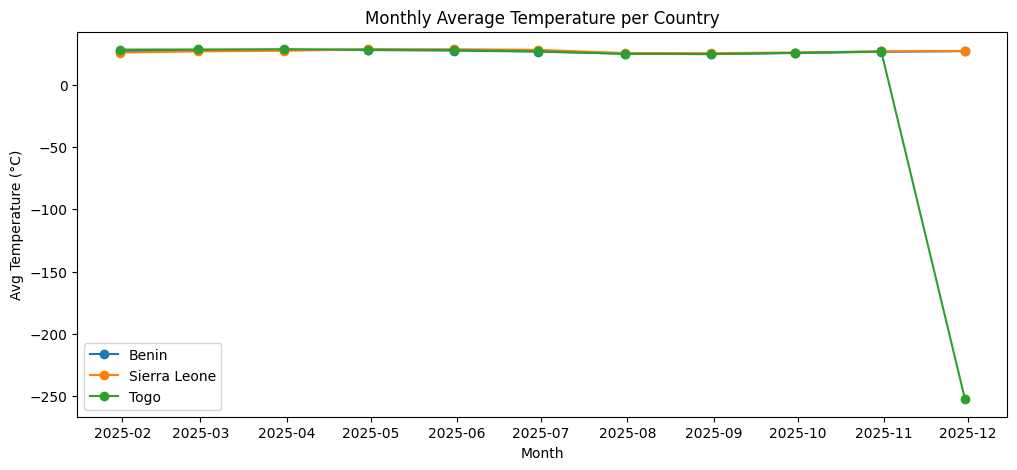

In [ ]:
# Plot monthly temperature per country
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

for country in monthly["Country"].unique():
    data = monthly[monthly["Country"] == country]
    plt.plot(data["Timestamp"], data["T2M"], marker="o", label=country)

plt.xlabel("Month")
plt.ylabel("Avg Temperature (°C)")
plt.title("Monthly Average Temperature per Country")
plt.legend()
plt.show()


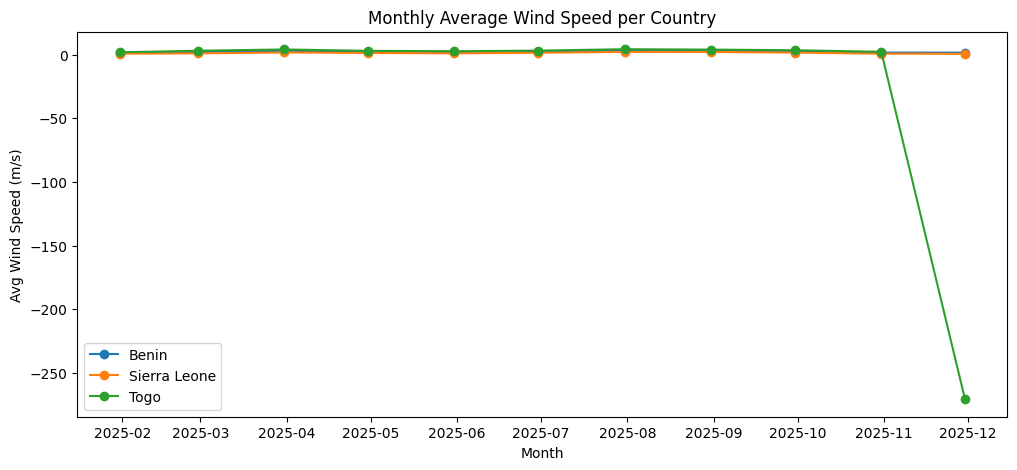

In [13]:
#Plot monthly wind speed per country
plt.figure(figsize=(12,5))

for country in monthly["Country"].unique():
    data = monthly[monthly["Country"] == country]
    plt.plot(data["Timestamp"], data["WS10M_MIN"], marker="o", label=country)

plt.xlabel("Month")
plt.ylabel("Avg Wind Speed (m/s)")
plt.title("Monthly Average Wind Speed per Country")
plt.legend()
plt.show()

In [14]:
# Summary stats per country
summary = all_countries.groupby("Country")[["T2M", "WS10M_MIN"]].describe().round(2)
summary


T2M                                                    \
              count   mean    std     min    25%    50%    75%    max   
Country                                                                 
Benin         311.0  26.66   1.21   24.10  25.63  26.96  27.71  28.58   
Sierra Leone  312.0  26.90   1.32   23.06  25.81  26.83  27.82  29.85   
Togo          315.0  17.26  99.82 -999.00  25.78  27.37  28.34  29.09   

             WS10M_MIN                                               
                 count  mean    std     min   25%   50%   75%   max  
Country                                                              
Benin            311.0  2.42   0.93    0.11  1.87  2.61  3.07  4.82  
Sierra Leone     312.0  1.47   0.73    0.05  0.94  1.54  2.01  3.19  
Togo             315.0 -6.30  97.50 -999.00  2.44  3.40  4.14  6.14

In [ ]:
# Detect outliers
from scipy import stats
import numpy as np

for col in ["T2M", "WS10M_MIN"]:
    all_countries[f"{col}_zscore"] = np.abs(stats.zscore(all_countries[col]))

# Filter extreme outliers (z > 3)
outliers = all_countries[
    (all_countries["T2M_zscore"] > 3) | (all_countries["WS10M_MIN_zscore"] > 3)
]
outliers


,YEAR,MO,DY,T2M,WS10M_MIN,Country,T2M_zscore,WS10M_MIN_zscore
Timestamp,,,,,,,,
2025-11-09,2025,11,9,-999.0,-999.0,Togo,17.649343,17.650012
2025-11-10,2025,11,10,-999.0,-999.0,Togo,17.649343,17.650012
2025-11-11,2025,11,11,-999.0,-999.0,Togo,17.649343,17.650012


In [16]:
#Correlation analysis (temperature vs wind speed)
corr = (
    all_countries.groupby("Country")[["T2M", "WS10M_MIN"]].corr().unstack().iloc[:, 1]
)
corr


Country
Benin          -0.239201
Sierra Leone   -0.296477
Togo            0.999767
Name: (T2M, WS10M_MIN), dtype: float64

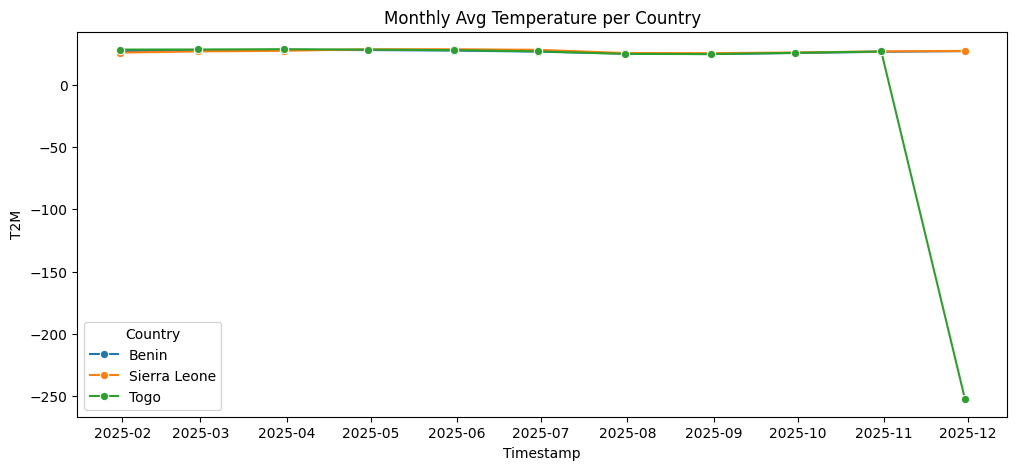

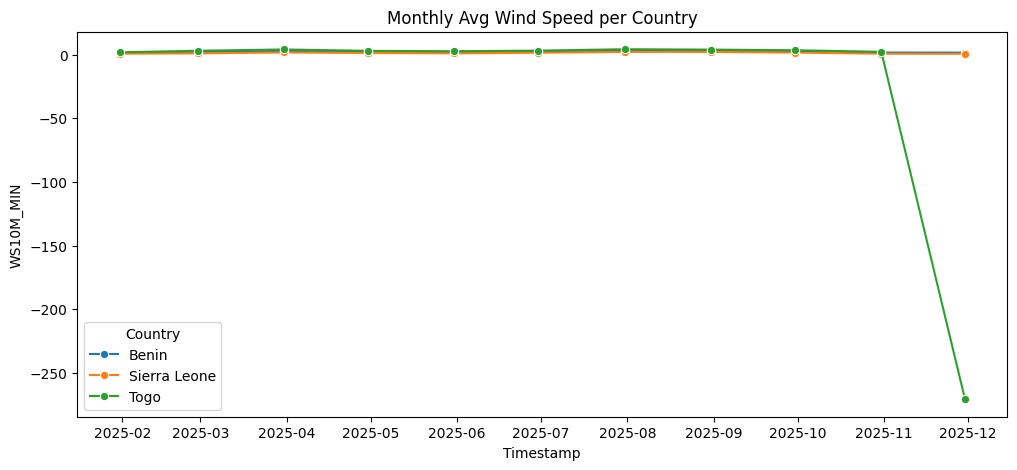

In [ ]:
# Monthly comparison plots
import seaborn as sns

# Temperature comparison
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x="Timestamp", y="T2M", hue="Country", marker="o")
plt.title("Monthly Avg Temperature per Country")
plt.show()

# Wind speed comparison
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x="Timestamp", y="WS10M_MIN", hue="Country", marker="o")
plt.title("Monthly Avg Wind Speed per Country")
plt.show()


In [18]:
# Resample by month and compute mean per country
monthly = all_countries.groupby("Country").resample("M").mean().reset_index()

# Preview
monthly.head()


C:\Users\hp\AppData\Local\Temp\ipykernel_12552\2944834555.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = all_countries.groupby("Country").resample("M").mean().reset_index()


,Country,Timestamp,YEAR,MO,DY,T2M,WS10M_MIN,T2M_zscore,WS10M_MIN_zscore
0,Benin,2025-01-31,2025.0,1.0,16.0,27.022903,1.326129,0.059391,0.038036
1,Benin,2025-02-28,2025.0,2.0,14.5,27.675357,2.141786,0.070652,0.052459
2,Benin,2025-03-31,2025.0,3.0,16.0,28.069677,3.070323,0.077458,0.068877
3,Benin,2025-04-30,2025.0,4.0,15.5,27.899667,2.413333,0.074524,0.057260
4,Benin,2025-05-31,2025.0,5.0,16.0,27.495161,2.158710,0.067542,0.052758
